<a href="https://colab.research.google.com/github/khalidpark/machinelearning_whitepaper/blob/main/Machine_learning_whitepaper_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/chocolate_bar_ratings/flavors_of_cacao.csv')

In [ ]:
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [ ]:
df.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

### 칼럼명 정리

In [ ]:
df.columns = ['company','specificOrigin','ref','reviewDate','cocoaPercent','companyLocation','rating','beanType','broadOrigin']

### 결측치 확인

In [ ]:
[(x, df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()]

[('beanType', 1), ('broadOrigin', 1)]

In [ ]:
df.dtypes

company             object
specificOrigin      object
ref                  int64
reviewDate           int64
cocoaPercent        object
companyLocation     object
rating             float64
beanType            object
broadOrigin         object
dtype: object

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company,1795,416,Soma,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
specificOrigin,1795,1039,Madagascar,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref,1795,NaN,NaN,NaN,1035.9,552.886,5,576,1069,1502,1952
reviewDate,1795,NaN,NaN,NaN,2012.33,2.92721,2006,2010,2013,2015,2017
cocoaPercent,1795,45,70%,672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
companyLocation,1795,60,U.S.A.,764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,1795,NaN,NaN,NaN,3.18593,0.478062,1,2.875,3.25,3.5,5
beanType,1794,41,,887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
broadOrigin,1794,100,Venezuela,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### rating이 타겟특성인데 실수형

In [ ]:
df['rating'].describe()

count    1795.000000
mean        3.185933
std         0.478062
min         1.000000
25%         2.875000
50%         3.250000
75%         3.500000
max         5.000000
Name: rating, dtype: float64

### 분포 확인

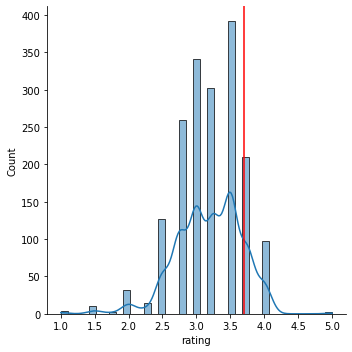

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df['rating'],kde=True);
plt.axvline(3.7, color='red');

### rating 이진타입으로 변형하여 분류문제로 전환

In [ ]:
## recommend 특성을 만들어 이진분류문제로 변환합니다
df['recommend'] = df['rating'] >= 3.7
df['recommend'].nunique()

2

In [ ]:
    df['recommend'].value_counts()

False    1485
True      310
Name: recommend, dtype: int64

### 데이터 전처리

In [ ]:
df['cocoaPercent'].head()

0    63%
1    70%
2    70%
3    70%
4    70%
Name: cocoaPercent, dtype: object

In [ ]:
df['broadOrigin'].unique()

array(['Sao Tome', 'Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama',
       'Madagascar', 'Brazil', 'Ecuador', 'Colombia', 'Burma',
       'Papua New Guinea', 'Bolivia', 'Fiji', 'Mexico', 'Indonesia',
       'Trinidad', 'Vietnam', 'Nicaragua', 'Tanzania',
       'Dominican Republic', 'Ghana', 'Belize', '\xa0', 'Jamaica',
       'Grenada', 'Guatemala', 'Honduras', 'Costa Rica',
       'Domincan Republic', 'Haiti', 'Congo', 'Philippines', 'Malaysia',
       'Dominican Rep., Bali', 'Venez,Africa,Brasil,Peru,Mex', 'Gabon',
       'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico', 'Uganda',
       'Martinique', 'Sao Tome & Principe', 'Vanuatu', 'Australia',
       'Liberia', 'Ecuador, Costa Rica', 'West Africa', 'Hawaii',
       'St. Lucia', 'Cost Rica, Ven', 'Peru, Madagascar',
       'Venezuela, Trinidad', 'Trinidad, Tobago',
       'Ven, Trinidad, Ecuador', 'South America, Africa', 'India',
       'Africa, Carribean, C. Am.', 'Tobago', 'Ven., Indonesia, Ecuad.',
       'Trinidad-Tobago

In [ ]:
import re

# broadOrigin 텍스트를 수정하기 위한 함수입니다.
def txt_prep(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        ['\.',''],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

In [ ]:
# 몇가지 간단하게 수정할 수 있는 부분만 전처리 합니다.
def preprocess (df):

    df.dropna(inplace=True)
    
    df['cocoaPercent'] = df['cocoaPercent'].str.replace('%','').astype(float)/100
    
    df['broadOrigin'] = df['broadOrigin'].apply(txt_prep)
    
    df['companyLocation'] = df['companyLocation']\
        .str.replace('Amsterdam', 'Holland')\
        .str.replace('U.K.', 'England')\
        .str.replace('Niacragua', 'Nicaragua')\
        .str.replace('Domincan Republic', 'Dominican Republic')
    
    df['beanType'] = df['beanType'].apply(lambda x : 'Missing' if (x is "\xa0") else x)
    
    df['is_blend'] = np.where(
    np.logical_or(
        np.logical_or(df['specificOrigin'].str.lower().str.contains(',|blend|;'),
                      df['broadOrigin'].str.len() == 1),
        df['broadOrigin'].str.lower().str.contains(',')
    )
    , 1
    , 0
)
    
    return df

df = preprocess(df)

In [ ]:
df['is_blend'].value_counts()

0    1095
1     698
Name: is_blend, dtype: int64

### 정보 누수 확인

In [ ]:
df.isna().sum().sort_values()

company            0
specificOrigin     0
ref                0
reviewDate         0
cocoaPercent       0
companyLocation    0
rating             0
beanType           0
broadOrigin        0
recommend          0
is_blend           0
dtype: int64

In [ ]:
df['reviewDate'].value_counts().sort_index()

2006     72
2007     77
2008     93
2009    123
2010    111
2011    164
2012    194
2013    184
2014    247
2015    285
2016    219
2017     24
Name: reviewDate, dtype: int64

### 데이터 분할 (훈련/검증세트)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=2)
train.shape, val.shape

((1434, 11), (359, 11))

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.2MB/s 


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'recommend'
features = df.columns.drop([target, 'reviewDate'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


검증 정확도:  1.0


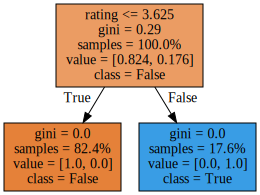

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

### 정보 누수 컬럼 제거

In [ ]:
features = df.columns.drop([target
                            , 'reviewDate'
                            , 'rating'
                            , 'ref'
                           ])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.83008356545961


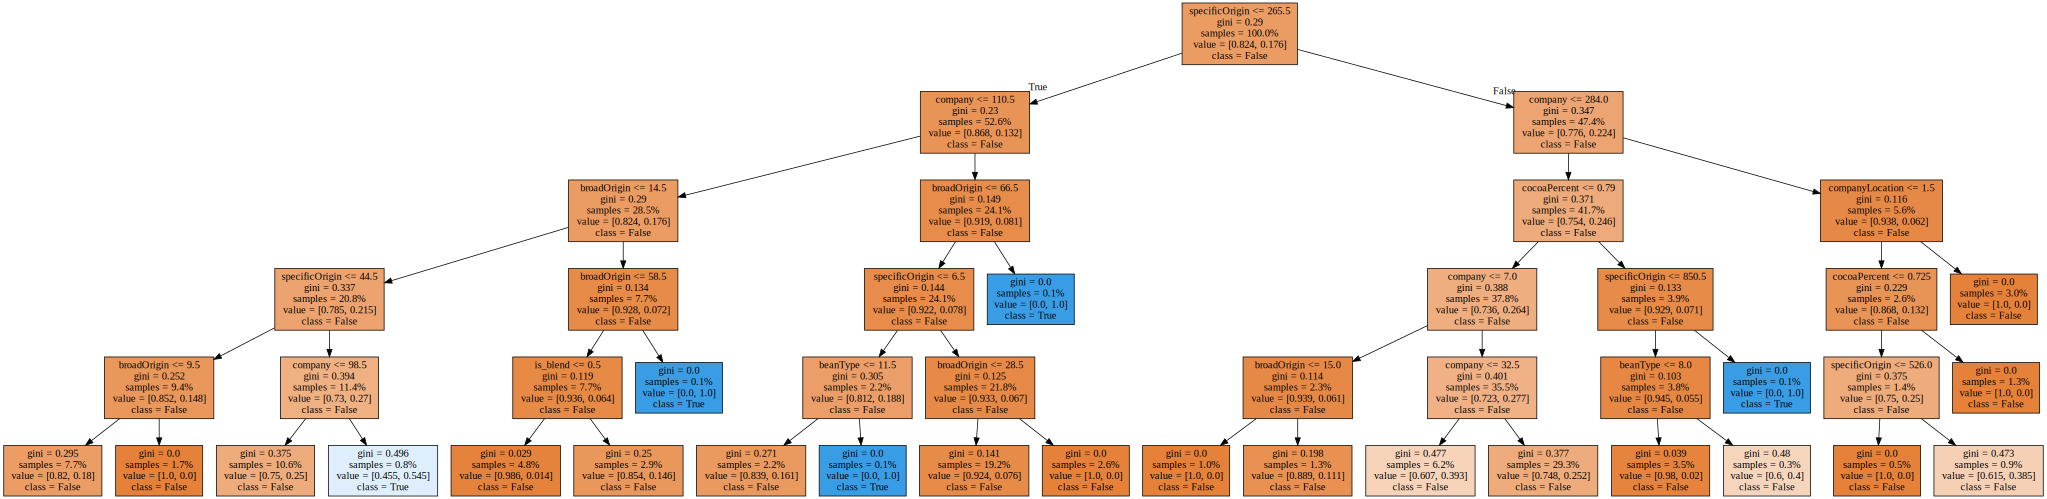

In [ ]:
tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

### 문제에 적합한 평가지표 선택

### **분류 & 회귀 모델의 평가지표 완전히 다르다!**

- Scikit-learn metrics

- 분류(classification) metrics

- 회귀(regression) metrics


### 분류문제에서는 정밀도, 재현율, ROC curve, AUC 등을 같이 사용해야함

Text(0.5, 1.0, 'Confusion matrix, n = 359')

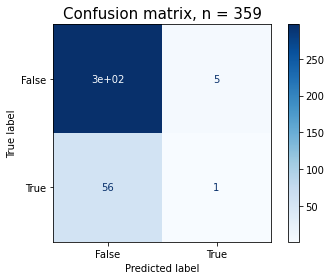

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.83008356545961


In [ ]:
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.98      0.91       302
        True       0.17      0.02      0.03        57

    accuracy                           0.83       359
   macro avg       0.50      0.50      0.47       359
weighted avg       0.73      0.83      0.77       359



In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.5991634715928895


Text(0, 0.5, 'TPR')

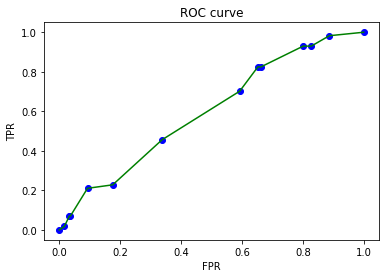

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### 타겟 특성의 클래스 비율이 차이가 많이 날 경우

1. 데이터가 적은 범주 데이터의 손실을 계산할 때 가중치를 더 곱하여 데이터의 균형을 맞추거나
2. 적은 범주 데이터를 추가샘플링(oversampling)하거나 반대로 많은 범주 데이터를 적게 샘플링(undersampling)하는 방법

### 범주의 비율 확인

`class_weight`에서 원하는 비율을 적용하거나 

`class_weight='balance'` 옵션을 사용

In [ ]:
y_train.value_counts(normalize=True)

False    0.824268
True     0.175732
Name: recommend, dtype: float64

In [ ]:
# class weights 계산
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train)/(2*np.bincount(y_train))
custom

array([0.60659898, 2.8452381 ])

In [ ]:
    pipe = make_pipeline(
        OrdinalEncoder(), 
    #     DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=2)
        DecisionTreeClassifier(max_depth=5, class_weight={False:custom[0],True:custom[1]}, random_state=2)
    )


    pipe.fit(X_train, y_train)
    print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.5793871866295265


Text(0.5, 1.0, 'Confusion matrix, n = 359')

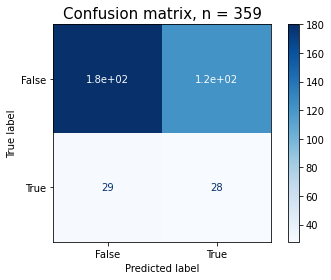

In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

### True 범주 수치 비교

In [ ]:
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.60      0.70       302
        True       0.19      0.49      0.27        57

    accuracy                           0.58       359
   macro avg       0.52      0.54      0.49       359
weighted avg       0.75      0.58      0.64       359



AUC score:  0.6176658533751598


Text(0, 0.5, 'TPR')

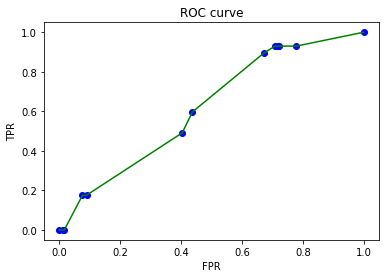

In [ ]:
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### 회귀문제에서는 타겟의 분포를 주의

In [ ]:
# house price 데이터를 사용합니다.
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv')

In [ ]:
target = df['SalePrice']

### 회귀분석에서는 타겟 분포가 비대칭 형태인지 확인

특성 변수들과 타겟변수의 분포가 정규분포 형태일때 좋은 성능을 보임. 

특히 타겟변수가 왜곡된 형태의 분포(skewed)일 경우 예측 성능에 부정적인 영향을 미침.

<img src="https://www.researchgate.net/profile/Marco_Faria/publication/294890337/figure/fig5/AS:668873900716049@1536483373457/a-Negative-skewness-b-Normal-curve-c-Positive-skewness-Durkhure-and-Lodwal-2014.ppm" />

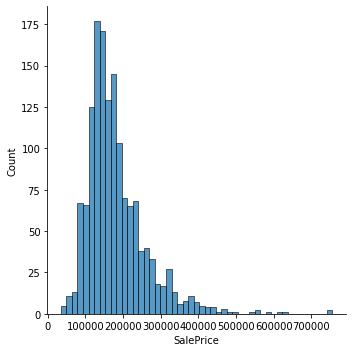

In [ ]:
# 타겟 분포가 right(positively) skewed
sns.displot(target);

### 이상치가 포함. 제거

In [ ]:
import numpy as np

## 타겟 이상치(outlier)를 제거.
df['SalePrice'] = df[df['SalePrice'] < np.percentile(df['SalePrice'], 99.5)]['SalePrice']

## 몇몇 변수를 합치고 이상치를 제거.
df['All_Flr_SF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['All_Liv_SF'] = df['All_Flr_SF'] + df['LowQualFinSF'] + df['GrLivArea']
df = df.drop(['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea'], axis=1)

df['All_Flr_SF'] = df[df['All_Flr_SF'] < np.percentile(df['All_Flr_SF'], 99.5)]['All_Flr_SF']
df['All_Liv_SF'] = df[df['All_Liv_SF'] < np.percentile(df['All_Liv_SF'], 99.5)]['All_Liv_SF']


In [ ]:
df['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

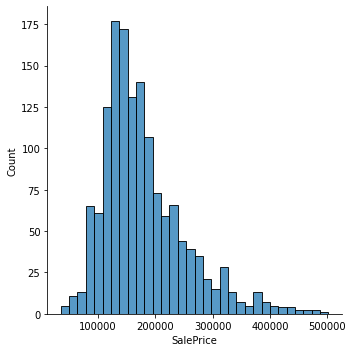

In [ ]:
#  여전히 right-skewed 상태
target = df['SalePrice']
sns.displot(target);

### 로그변환(Log-Transform)

타겟이 right-skewed 상태라면 로그변환을 사용 

비대칭 분포형태를 정규분포형태로 변환

<img src="https://www.researchgate.net/profile/Matthieu_Komorowski4/publication/308022342/figure/fig3/AS:405548043390978@1473701596576/Example-of-the-effect-of-a-log-transformation-on-the-distribution-of-the-dataset.png" width="600" />

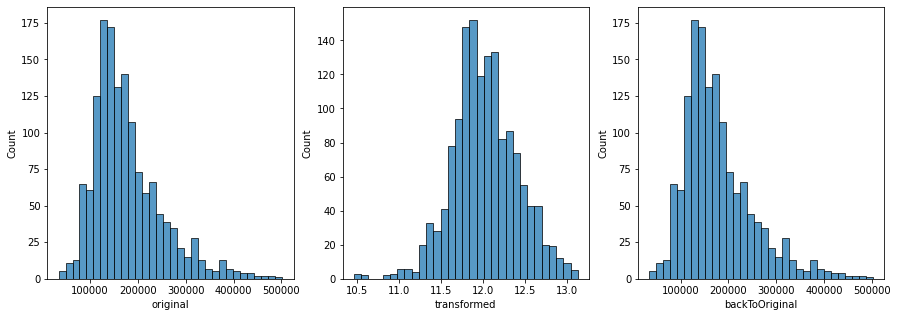

In [ ]:
plots=pd.DataFrame()
plots['original']=target
plots['transformed']=np.log1p(target)
plots['backToOriginal']=np.expm1(np.log1p(target))

fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(plots['original'], ax=ax[0]);
sns.histplot(plots['transformed'], ax=ax[1]);
sns.histplot(plots['backToOriginal'], ax=ax[2]);

### RandomForestRegressor & TransformedTargetRegressor

In [ ]:
target = 'SalePrice'
from sklearn.model_selection import train_test_split

df = df[df[target].notna()]

train, val = train_test_split(df, test_size=260, random_state=2)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)


pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.8853294698484702

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)

tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.8882560489177405